In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

우리는 길이가 1000 인 리턴 계열이 각각 4 개인 애셋이 있다고 가정합니다. 
numpy.random.randn을 사용하여 정규 분포로부터의 수익률을 샘플링 할 수 있습니다.

In [2]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

Text(0,0.5,'returns')

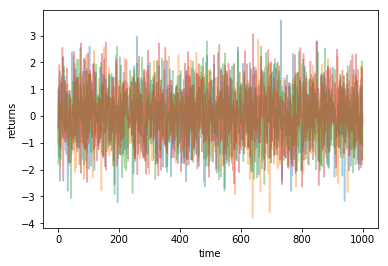

In [3]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

이 리턴 시리즈는 광범위한 포트폴리오를 생성하는 데 사용될 수 있습니다.
서로 다른 수익과 위험 (표준 편차)을 가져야합니다. 우리는 넓은 범위를 생산할 수 있습니다.
임의의 가중치 벡터를 선택하고 해당 포트폴리오를 그립니다. 
우리가 모든 자본을 투자하기를 원할 때,이 벡터는 합계가 1이되어야합니다.

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print (rand_weights(n_assets))
print (rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


다음으로, 얼마나 많은 랜덤 포트폴리오가 수행 될지 평가할 수 있습니다. 
이 목표를 향해 평균 수익률과 변동성 (여기서는 표준 편차를 사용함)을 계산합니다. 
거기 있음을 볼 수도 있습니다.
더 나은 설명을 위해 표준 편차가 <2 인 포트폴리오 만 플로팅 할 수있는 필터.

In [5]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

코드에서 다음과 함께 수익을 계산합니다.

기대 수익률은 평균에 대한 벡터의 전치입니다.
각 시계열에 대한 수익률 및 w는 포트폴리오의 가중치 벡터입니다. Nx1이다.
열 벡터이므로 곱해질 수있는 1xN 행 벡터가됩니다.
Nx1 가중치 (열) 벡터를 사용하여 스칼라 결과를 얻습니다. 이것은 점과 같습니다.
코드에 사용 된 제품. 파이썬은 다음과 같은 정의를 가지고있다.
행 및 열 및 이전 방정식의 정확한 NumPy 버전은 R = w * p.T 일 수있다.

다음으로 표준 편차를 다음과 같이 계산합니다.

여기서 NxN 행렬 인 리턴의 공분산 행렬입니다. 
부디 우리가 std (array (ret_vec) .T * w)를 사용하여 적절한 가중치를 가진 간단한 표준 편차를 간단히 계산했다면,'bullet'. 
단순한 표준 편차를 계산할 수 없기 때문입니다.

공분산. 공분산 행렬에서 대각선의 값 각 자산의 단순한 차이를 나타내는 반면, 대각선은 자산 간의 차이입니다. 보통 std ()를 사용함으로써 우리는 대각선으로 나머지는 그리워. 작지만 중요한 차이.

500 개의 임의의 포트폴리오에 대한 평균 수익률과 변동성을 생성 할 수 있습니다.

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

그(것)들을 음모를 꾸미기에 당신은 특성 포물선을 형성 한다는 것을 관찰 할 것이다
'마코 위츠 탄환 (Markowitz bullet)'이라고 불리는 모양을 '효율적인
프론티어 (frontier) '에서 우리는 주어진 기대치에 대해 가장 낮은 분산을 보입니다.

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

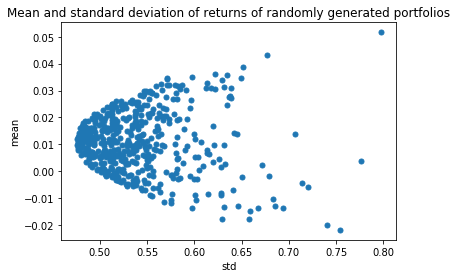

In [7]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

Markowitz 최적화와 효율적인 경계

파란색 점이 표시되면서 포트폴리오를 잘 나타내면 효율적인 프론티어 Markowitz 스타일을 계산할 수 있습니다. 이것은 최소화함으로써 이루어집니다.


기대 포트폴리오 수익에 대한 모든 합계를 유지하면서
무게는 1 :

여기서는 매개 변수 적으로 실행하여 최소 분산을 찾습니다.
다른 사람들을 위해서. 이것은 scipy.optimise.minimize로 할 수 있지만
bounds, constraints, Lagrange multiplier에 대한 복잡한 문제를 정의한다. 

편리하게도, cvxopt 패키지 (convex solver)는 우리 모두를위한 것입니다. 
우리는 아래에 표시된 것과 같이 몇 가지 수정 사항을 사용하여 예제 중 하나를 사용했습니다. 
코드에 컨디셔닝 표현이 있음을 알 수 있습니다. 
그것들은 문제를 설정하기 위해서 간단히 필요합니다. 
자세한 내용은 cvxopt 예제를 참조하십시오.

mus 벡터는 일련의 예상 된 반환 값을 비선형적이고보다 적절한 방식으로 생성합니다. 
나중에 더 많은 값을 계산할 필요가 없다는 것을 나중에 알게 될 것입니다. 
포물선에 완전히 딱 들어 맞으므로 더 높은 값에 대해 외삽 할 수 있습니다.

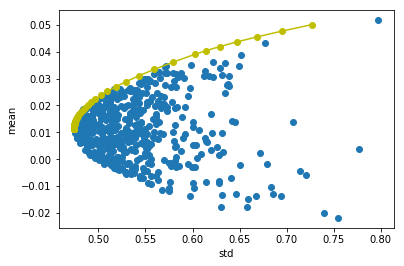

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

노란색에서는 원하는 각 수익 (즉, mus)에 대한 최적의 포트폴리오를 볼 수 있습니다. 또한, 우리는 하나의 최적 포트폴리오를 반환합니다 :

In [9]:
print (weights)

[[2.77880107e-09]
 [3.20322848e-06]
 [1.54301198e-06]
 [9.99995251e-01]]
